In [15]:
import pandas as pd
import numpy as np
from pathlib import Path

BASE = Path("/Users/bernardbarnieh/Documents/msr2026-aidev/data/processed")

# 1) Load PR spine (one row per PR)
prs = pd.read_parquet(BASE / "combined_pr_pop.parquet")
print("PRS shape:", prs.shape)
print("PRS columns sample:", prs.columns.tolist()[:25])

PRS shape: (40214, 14)
PRS columns sample: ['agent', 'body', 'closed_at', 'created_at', 'html_url', 'id', 'merged_at', 'number', 'repo_url', 'state', 'title', 'user', 'user_id', 'author_type']


In [16]:
[c for c in prs.columns if "author" in c.lower() or "agent" in c.lower() or "bot" in c.lower()]

['agent', 'author_type']

In [17]:
print(prs["author_type"].value_counts(dropna=False).head(10))
prs = prs[prs["author_type"].eq("agent")].copy()
prs["author_type"].value_counts(dropna=False)
print("Agent-only PRS shape:", prs.shape)

author_type
agent    33596
human     6618
Name: count, dtype: int64
Agent-only PRS shape: (33596, 14)


In [18]:
print(prs.shape)
prs.head(2)

(33596, 14)


,agent,body,closed_at,created_at,html_url,id,merged_at,number,repo_url,state,title,user,user_id,author_type
0,Claude_Code,## Summary\n\nFixes an issue where `load_colle...,2025-07-29T07:01:20Z,2025-07-26 02:59:01+00:00,https://github.com/milvus-io/pymilvus/pull/2911,3264933329,None,2911,https://api.github.com/repos/milvus-io/pymilvus,closed,Fix: Wait for all partitions in load_collectio...,weiliu1031,108661493,agent
1,Claude_Code,## 背景\n\n現在、本プロジェクトにおいて以下のパス構成の不整合が生じています：\n\n...,2025-07-26T22:12:24Z,2025-07-26 04:56:55+00:00,https://github.com/classmethod/tsumiki/pull/2,3265118634,2025-07-26T22:12:24Z,2,https://api.github.com/repos/classmethod/tsumiki,closed,ファイルパス参照を相対パスに統一し、doc/からdocs/に統一,cm-kojimat,61827001,agent


In [19]:
out_path = BASE / "agent_prs_only.parquet"
prs.to_parquet(out_path, index=False)
print("Saved:", out_path)

Saved: /Users/bernardbarnieh/Documents/msr2026-aidev/data/processed/agent_prs_only.parquet


/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


In [20]:
# merged label
prs["y_merged"] = prs["merged_at"].notna()  # True = merged

# Keep only resolved PRs (merged OR closed)
prs_resolved = prs[prs["state"].isin(["closed"])].copy()

# In resolved PRs: rejected = closed but not merged
prs_resolved["y_rejected"] = (~prs_resolved["y_merged"])

prs_resolved[["id","number","repo_url","state","merged_at","y_merged","y_rejected"]].head()
print(prs_resolved["y_merged"].value_counts(dropna=False))

y_merged
True     24014
False     7270
Name: count, dtype: int64


In [21]:
# --- Sanity checks ---
print("prs (agent-only) shape:", prs.shape)
print("prs_resolved shape:", prs_resolved.shape)

# Make sure no humans slipped in
if "author_type" in prs.columns:
    print("prs author_type:", prs["author_type"].value_counts(dropna=False))

print("Label distribution (merged vs rejected):")
print(prs_resolved["y_merged"].value_counts(dropna=False))
print("Rejected count:", prs_resolved["y_rejected"].sum())

prs (agent-only) shape: (33596, 15)
prs_resolved shape: (31284, 16)
prs author_type: author_type
agent    33596
Name: count, dtype: int64
Label distribution (merged vs rejected):
y_merged
True     24014
False     7270
Name: count, dtype: int64
Rejected count: 7270


In [22]:
import pandas as pd
import numpy as np

wf = pd.read_csv(BASE / "agentic_prs_ci_output_worklfows.csv")

print("Raw workflows shape:", wf.shape)
print("author_type counts:", wf["author_type"].value_counts(dropna=False))

# Keep only agent workflows
wf = wf[wf["author_type"].eq("agent")].copy()
print("Agent workflows shape:", wf.shape)

# Keep only workflows belonging to our agent PRs
agent_pr_ids = set(prs_resolved["id"].astype(int))
wf["pr_id"] = wf["pr_id"].astype("Int64")

wf = wf[wf["pr_id"].isin(agent_pr_ids)].copy()
print("Agent workflows for prs_resolved shape:", wf.shape)

# Quick check: how many PRs have at least 1 workflow row?
print("PRs with >=1 workflow:", wf["pr_id"].nunique(), "out of", len(agent_pr_ids))

Raw workflows shape: (99976, 14)
author_type counts: author_type
agent    75115
human    24861
Name: count, dtype: int64
Agent workflows shape: (75115, 14)
Agent workflows for prs_resolved shape: (68861, 14)
PRs with >=1 workflow: 24226 out of 31284


In [23]:
# Parse timestamps (workflows)
for c in ["started_at", "finished_at", "workflow_run_url", "commit_sha"]:
    if c not in wf.columns:
        print("Missing column:", c)

wf["started_at"] = pd.to_datetime(wf["started_at"], errors="coerce", utc=True)
wf["finished_at"] = pd.to_datetime(wf["finished_at"], errors="coerce", utc=True)

# Parse PR created_at
prs_resolved["created_at"] = pd.to_datetime(prs_resolved["created_at"], errors="coerce", utc=True)

EARLY_HOURS = 24
early_delta = pd.Timedelta(hours=EARLY_HOURS)

# Attach PR created_at to each workflow row
wf = wf.merge(
    prs_resolved[["id", "created_at"]].rename(columns={"id": "pr_id"}),
    on="pr_id",
    how="left"
)

# Keep only early workflows (started within first EARLY_HOURS after PR creation)
wf["dt_from_create"] = wf["started_at"] - wf["created_at"]
wf_early = wf[(wf["dt_from_create"].notna()) & (wf["dt_from_create"] >= pd.Timedelta(0)) & (wf["dt_from_create"] <= early_delta)].copy()

print("Early workflows shape:", wf_early.shape)
print("PRs with >=1 early workflow:", wf_early["pr_id"].nunique())

Early workflows shape: (59073, 16)
PRs with >=1 early workflow: 22230


In [24]:
# Normalize conclusion/status (common values: success, failure, cancelled, skipped, neutral, timed_out, action_required, stale)
wf_early["conclusion"] = wf_early["conclusion"].astype(str).str.lower()
wf_early["status"] = wf_early["status"].astype(str).str.lower()

def agg_ci_features(df_one_pr: pd.DataFrame) -> pd.Series:
    # Sort by start time so "first run" is well-defined
    df_one_pr = df_one_pr.sort_values("started_at")

    n_runs = len(df_one_pr)

    first_started = df_one_pr["started_at"].iloc[0]
    first_conc = df_one_pr["conclusion"].iloc[0]

    # Define failure-ish outcomes
    fail_set = {"failure", "timed_out", "cancelled", "action_required"}
    succ_set = {"success"}

    n_success = df_one_pr["conclusion"].isin(succ_set).sum()
    n_fail = df_one_pr["conclusion"].isin(fail_set).sum()

    any_fail = int(n_fail > 0)
    any_success = int(n_success > 0)

    # If duration_seconds exists (your RQ1 file had duration_seconds; your workflow CSV shows it too)
    dur = pd.to_numeric(df_one_pr.get("duration_seconds", pd.Series([np.nan]*n_runs)), errors="coerce")
    dur_mean = dur.mean()
    dur_median = dur.median()

    # time to first CI (minutes from PR creation)
    dt_first = (first_started - df_one_pr["created_at"].iloc[0])
    time_to_first_ci_min = dt_first.total_seconds() / 60 if pd.notna(dt_first) else np.nan

    return pd.Series({
        "early_ci_runs": n_runs,
        "early_ci_any_fail": any_fail,
        "early_ci_any_success": any_success,
        "early_ci_fail_count": n_fail,
        "early_ci_success_count": n_success,
        "early_ci_fail_rate": (n_fail / n_runs) if n_runs else 0.0,
        "early_ci_first_conclusion": first_conc,
        "early_ci_time_to_first_min": time_to_first_ci_min,
        "early_ci_duration_mean_s": dur_mean,
        "early_ci_duration_median_s": dur_median
    })

ci_feat = wf_early.groupby("pr_id").apply(agg_ci_features).reset_index()
ci_feat.rename(columns={"pr_id": "id"}, inplace=True)

print("CI feature table shape:", ci_feat.shape)
ci_feat.head()

CI feature table shape: (22230, 11)


,id,early_ci_runs,early_ci_any_fail,early_ci_any_success,early_ci_fail_count,early_ci_success_count,early_ci_fail_rate,early_ci_first_conclusion,early_ci_time_to_first_min,early_ci_duration_mean_s,early_ci_duration_median_s
0,2756921963,4,1,1,3,1,0.750000,failure,523.100000,129.250000,118.5
1,2757103560,3,1,1,2,1,0.666667,success,150.483333,252.000000,269.0
2,2757124156,3,0,1,0,3,0.000000,success,0.066667,22.666667,27.0
3,2757125491,3,0,1,0,3,0.000000,success,0.066667,25.666667,31.0
4,2757179026,4,0,1,0,4,0.000000,success,19.833333,15.250000,14.0


In [25]:
# PR text length features
prs_resolved["title"] = prs_resolved["title"].fillna("")
prs_resolved["body"] = prs_resolved["body"].fillna("")

prs_resolved["title_len"] = prs_resolved["title"].str.len()
prs_resolved["body_len"] = prs_resolved["body"].str.len()

# Time features from PR creation time
prs_resolved["created_dow"] = prs_resolved["created_at"].dt.dayofweek  # 0=Mon
prs_resolved["created_hour"] = prs_resolved["created_at"].dt.hour

# Optional: repo identifier (careful with leakage/high-cardinality; keep for grouping/splits)
prs_resolved["repo_url"] = prs_resolved["repo_url"].fillna("")

In [26]:
df_model = prs_resolved.merge(ci_feat, on="id", how="left")

# If a PR has no early workflows, fill CI features with safe defaults
df_model["early_ci_runs"] = df_model["early_ci_runs"].fillna(0)
df_model["early_ci_any_fail"] = df_model["early_ci_any_fail"].fillna(0)
df_model["early_ci_any_success"] = df_model["early_ci_any_success"].fillna(0)
df_model["early_ci_fail_count"] = df_model["early_ci_fail_count"].fillna(0)
df_model["early_ci_success_count"] = df_model["early_ci_success_count"].fillna(0)
df_model["early_ci_fail_rate"] = df_model["early_ci_fail_rate"].fillna(0.0)
df_model["early_ci_time_to_first_min"] = df_model["early_ci_time_to_first_min"].fillna(np.nan)  # keep NaN -> impute later
df_model["early_ci_duration_mean_s"] = df_model["early_ci_duration_mean_s"].fillna(np.nan)
df_model["early_ci_duration_median_s"] = df_model["early_ci_duration_median_s"].fillna(np.nan)
df_model["early_ci_first_conclusion"] = df_model["early_ci_first_conclusion"].fillna("no_ci_in_early_window")

print("Model table shape:", df_model.shape)
print("Target (y_merged) distribution:")
print(df_model["y_merged"].value_counts(dropna=False))

Model table shape: (31284, 30)
Target (y_merged) distribution:
y_merged
True     24014
False     7270
Name: count, dtype: int64


In [27]:
# Target
target = "y_merged"          # 1=merged, 0=rejected
y = df_model[target].astype(int)

# Features (use the exact columns you used before)
num_cols = [
    "title_len", "body_len", "created_dow", "created_hour",
    "early_ci_runs", "early_ci_any_fail", "early_ci_any_success",
    "early_ci_fail_count", "early_ci_success_count", "early_ci_fail_rate",
    "early_ci_time_to_first_min", "early_ci_duration_mean_s", "early_ci_duration_median_s"
]
cat_cols = ["early_ci_first_conclusion"]

X = df_model[num_cols + cat_cols].copy()

# Groups
groups = df_model["repo_url"].fillna("unknown_repo")

In [28]:
from sklearn.model_selection import GroupShuffleSplit

# Use repo_url as grouping key (same repo should not be in both train and test)
groups = df_model["repo_url"].fillna("unknown_repo")

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print("Train size:", X_train.shape, "Test size:", X_test.shape)
print("Train label balance:", y_train.mean().round(3), "Test label balance:", y_test.mean().round(3))
print("Unique repos in train:", df_model.iloc[train_idx]["repo_url"].nunique())
print("Unique repos in test:", df_model.iloc[test_idx]["repo_url"].nunique())

Train size: (24643, 14) Test size: (6641, 14)
Train label balance: 0.742 Test label balance: 0.864
Unique repos in train: 1923
Unique repos in test: 481


/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [29]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

target = "y_merged"   # True = merged, False = rejected
y = df_model[target].astype(int)

# Feature columns (keep it simple + early-only)
num_cols = [
    "title_len", "body_len", "created_dow", "created_hour",
    "early_ci_runs", "early_ci_any_fail", "early_ci_any_success",
    "early_ci_fail_count", "early_ci_success_count", "early_ci_fail_rate",
    "early_ci_time_to_first_min", "early_ci_duration_mean_s", "early_ci_duration_median_s"
]
cat_cols = ["early_ci_first_conclusion"]  # low-cardinality-ish

X = df_model[num_cols + cat_cols].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median"))
        ]), num_cols),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
    ],
    remainder="drop"
)

clf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

clf.fit(X_train, y_train)

proba = clf.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(y_test, proba))
print("PR-AUC:", average_precision_score(y_test, proba))
print(classification_report(y_test, pred, digits=3))

/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in 

ROC-AUC: 0.6078376622130655
PR-AUC: 0.8136712985380811
              precision    recall  f1-score   support

           0      0.291     0.567     0.385      1454
           1      0.816     0.582     0.680      4803

    accuracy                          0.579      6257
   macro avg      0.554     0.575     0.532      6257
weighted avg      0.694     0.579     0.611      6257



/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in 

In [30]:
out_path = BASE / "rq2_agentic_early_features_merged_vs_rejected.parquet"
df_model.to_parquet(out_path, index=False)
print("Saved:", out_path)

/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Saved: /Users/bernardbarnieh/Documents/msr2026-aidev/data/processed/rq2_agentic_early_features_merged_vs_rejected.parquet


In [31]:
from sklearn.model_selection import GroupShuffleSplit

# Ensure repo_url exists
df_model["repo_url"] = df_model["repo_url"].fillna("unknown_repo")

target = "y_merged"  # 1=merged, 0=rejected
y = df_model[target].astype(int)

# Features you already selected
num_cols = [
    "title_len", "body_len", "created_dow", "created_hour",
    "early_ci_runs", "early_ci_any_fail", "early_ci_any_success",
    "early_ci_fail_count", "early_ci_success_count", "early_ci_fail_rate",
    "early_ci_time_to_first_min", "early_ci_duration_mean_s", "early_ci_duration_median_s"
]
cat_cols = ["early_ci_first_conclusion"]

# Keep only columns that exist (safe guard)
all_cols = [c for c in (num_cols + cat_cols + ["repo_url"]) if c in df_model.columns]
X = df_model[all_cols].copy()

groups = df_model["repo_url"]

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train = X.iloc[train_idx].drop(columns=["repo_url"])
X_test  = X.iloc[test_idx].drop(columns=["repo_url"])
y_train = y.iloc[train_idx]
y_test  = y.iloc[test_idx]

print("Train size:", X_train.shape, "Test size:", X_test.shape)
print("Train merged rate:", y_train.mean().round(3), "Test merged rate:", y_test.mean().round(3))

/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Train size: (24643, 14) Test size: (6641, 14)
Train merged rate: 0.742 Test merged rate: 0.864


In [32]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix

# Preprocess
numeric_features = [c for c in num_cols if c in X_train.columns]
categorical_features = [c for c in cat_cols if c in X_train.columns]

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median"))
        ]), numeric_features),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), categorical_features),
    ],
    remainder="drop"
)

clf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

clf.fit(X_train, y_train)

proba = clf.predict_proba(X_test)[:, 1]  # P(merged)
pred = (proba >= 0.5).astype(int)

roc = roc_auc_score(y_test, proba)
pr  = average_precision_score(y_test, proba)

baseline_pr = y_test.mean()  # random ranking PR-AUC baseline ~ prevalence
print("ROC-AUC:", roc)
print("PR-AUC:", pr, " | baseline PR-AUC (prevalence):", baseline_pr)
print("\nClassification report (threshold=0.5):")
print(classification_report(y_test, pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, pred))

/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in 

ROC-AUC: 0.5923995543001573
PR-AUC: 0.8926078903957982  | baseline PR-AUC (prevalence): 0.8641770817647945

Classification report (threshold=0.5):
              precision    recall  f1-score   support

           0      0.155     0.657     0.251       902
           1      0.891     0.439     0.588      5739

    accuracy                          0.468      6641
   macro avg      0.523     0.548     0.420      6641
weighted avg      0.791     0.468     0.542      6641

Confusion matrix:
 [[ 593  309]
 [3222 2517]]


/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in 

/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Spa

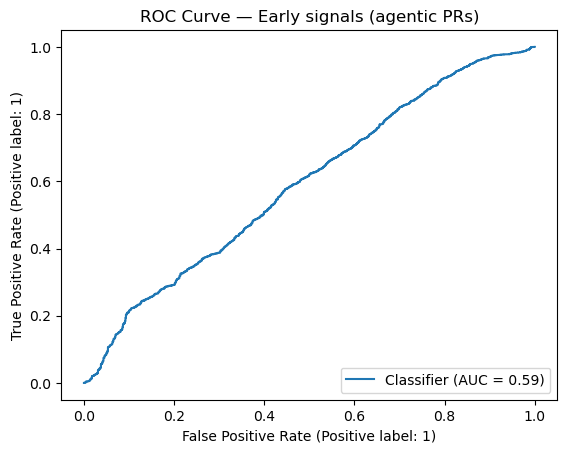

/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Spa

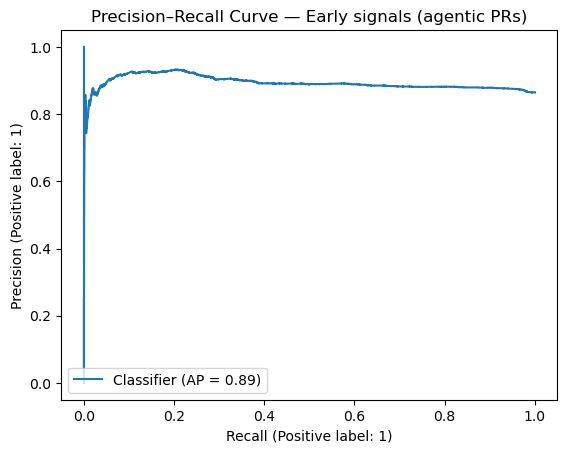

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

RocCurveDisplay.from_predictions(y_test, proba)
plt.title("ROC Curve — Early signals (agentic PRs)")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, proba)
plt.title("Precision–Recall Curve — Early signals (agentic PRs)")
plt.show()

In [34]:
import numpy as np
from sklearn.metrics import f1_score

thresholds = np.linspace(0.05, 0.95, 19)

# If proba is P(merged), then P(rejected)=1-proba
p_reject = 1 - proba

best = None
for t in thresholds:
    pred_reject = (p_reject >= t).astype(int)  # 1 = predict rejected
    y_reject = (y_test == 0).astype(int)

    f1 = f1_score(y_reject, pred_reject)
    if (best is None) or (f1 > best["f1"]):
        best = {"t": t, "f1": f1}

print("Best reject-threshold (by F1):", best)

Best reject-threshold (by F1): {'t': 0.44999999999999996, 'f1': 0.2577777777777778}


/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Spa

In [35]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    clf, X_test, y_test,
    n_repeats=5, random_state=42, scoring="roc_auc"
)

import pandas as pd
imp = pd.DataFrame({
    "feature": X_test.columns,
    "importance_mean": result.importances_mean,
    "importance_std": result.importances_std
}).sort_values("importance_mean", ascending=False)

print(imp.head(15))

/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Spa

                       feature  importance_mean  importance_std
1                     body_len         0.097857    5.537655e-03
2                  created_dow         0.017033    2.909132e-03
4                early_ci_runs         0.013439    3.998429e-03
0                    title_len         0.012619    6.128023e-04
3                 created_hour         0.008389    1.343717e-03
8       early_ci_success_count         0.005508    3.791220e-04
11    early_ci_duration_mean_s         0.000096    9.065866e-06
12  early_ci_duration_median_s         0.000006    9.970670e-07
9           early_ci_fail_rate        -0.001901    6.579827e-05
5            early_ci_any_fail        -0.004700    1.642115e-04
10  early_ci_time_to_first_min        -0.007574    5.854532e-04
6         early_ci_any_success        -0.009472    3.960000e-04
13   early_ci_first_conclusion        -0.009910    5.367588e-04
7          early_ci_fail_count        -0.042216    1.506906e-03


/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Spa

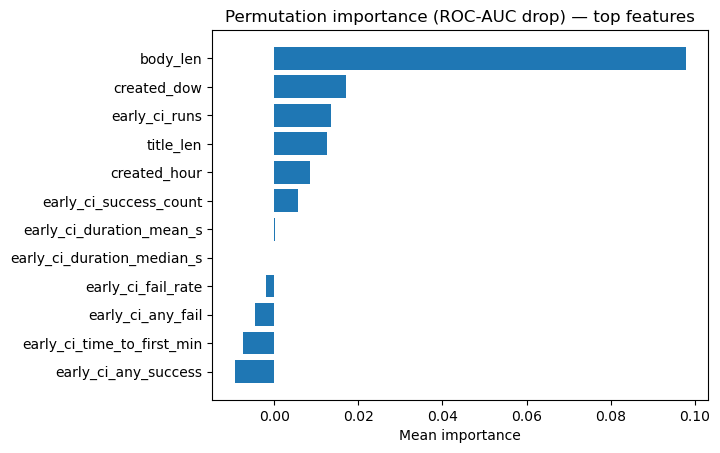

In [36]:
topk = 12
imp_top = imp.head(topk).iloc[::-1]  # reverse for nice horizontal plot

plt.figure()
plt.barh(imp_top["feature"], imp_top["importance_mean"])
plt.title("Permutation importance (ROC-AUC drop) — top features")
plt.xlabel("Mean importance")
plt.show()

In [37]:
meta_num = ["title_len","body_len","created_dow","created_hour"]
ci_num = [
    "early_ci_runs","early_ci_any_fail","early_ci_any_success",
    "early_ci_fail_count","early_ci_success_count","early_ci_fail_rate",
    "early_ci_time_to_first_min","early_ci_duration_mean_s","early_ci_duration_median_s"
]
cat_cols = ["early_ci_first_conclusion"]

def run_model(feature_cols):
    X2 = df_model[feature_cols].copy()
    y2 = df_model["y_merged"].astype(int)

    # group split (repo leakage-safe)
    groups = df_model["repo_url"].fillna("unknown_repo")
    from sklearn.model_selection import GroupShuffleSplit
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idx, test_idx = next(gss.split(X2, y2, groups=groups))

    X_train, X_test = X2.iloc[train_idx], X2.iloc[test_idx]
    y_train, y_test = y2.iloc[train_idx], y2.iloc[test_idx]

    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.impute import SimpleImputer
    from sklearn.pipeline import Pipeline
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import roc_auc_score, average_precision_score, classification_report

    # detect numeric vs categorical in this subset
    num_cols = [c for c in feature_cols if c != "early_ci_first_conclusion"]
    cat_cols_local = [c for c in feature_cols if c == "early_ci_first_conclusion"]

    preprocess = ColumnTransformer(
        transformers=[
            ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), num_cols),
            ("cat", Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("onehot", OneHotEncoder(handle_unknown="ignore"))
            ]), cat_cols_local),
        ],
        remainder="drop"
    )

    clf = Pipeline(steps=[
        ("prep", preprocess),
        ("model", LogisticRegression(max_iter=2000, class_weight="balanced"))
    ])

    clf.fit(X_train, y_train)
    proba = clf.predict_proba(X_test)[:, 1]
    pred = (proba >= 0.5).astype(int)

    print("Features:", feature_cols)
    print("ROC-AUC:", roc_auc_score(y_test, proba))
    print("PR-AUC:", average_precision_score(y_test, proba))
    print(classification_report(y_test, pred, digits=3))
    return clf

# 1) metadata-only
clf_meta = run_model(meta_num)

# 2) metadata + CI
clf_meta_ci = run_model(meta_num + ci_num + cat_cols)

/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in 

Features: ['title_len', 'body_len', 'created_dow', 'created_hour']
ROC-AUC: 0.6470792094700398
PR-AUC: 0.8969147838771712
              precision    recall  f1-score   support

           0      0.223     0.548     0.317       902
           1      0.908     0.700     0.791      5739

    accuracy                          0.680      6641
   macro avg      0.565     0.624     0.554      6641
weighted avg      0.815     0.680     0.726      6641

Features: ['title_len', 'body_len', 'created_dow', 'created_hour', 'early_ci_runs', 'early_ci_any_fail', 'early_ci_any_success', 'early_ci_fail_count', 'early_ci_success_count', 'early_ci_fail_rate', 'early_ci_time_to_first_min', 'early_ci_duration_mean_s', 'early_ci_duration_median_s', 'early_ci_first_conclusion']
ROC-AUC: 0.5923995543001573
PR-AUC: 0.8926078903957982
              precision    recall  f1-score   support

           0      0.155     0.657     0.251       902
           1      0.891     0.439     0.588      5739

    accuracy   

/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in 

In [38]:
import numpy as np

# Use your best model and leakage-safe split indices from earlier
proba = clf.predict_proba(X_test)[:, 1]

k = int(0.10 * len(proba))  # top 10% risky
top_idx = np.argsort(proba)[:k]  # if proba predicts merge, reverse; adjust below


# NOTE: your target is y_merged (1=merged). If you want "rejection risk",
# define rejection_proba = 1 - proba, and sort by that.
rejection_proba = 1 - proba
top_idx = np.argsort(-rejection_proba)[:k]  # highest rejection risk

top_reject_rate = (y_test.iloc[top_idx] == 0).mean()
overall_reject_rate = (y_test == 0).mean()

print("Overall rejection rate:", overall_reject_rate.round(3))
print("Top 10% predicted-risk rejection rate:", top_reject_rate.round(3))
print("Lift:", (top_reject_rate / overall_reject_rate).round(2))

Overall rejection rate: 0.136
Top 10% predicted-risk rejection rate: 0.255
Lift: 1.87


/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in 

In [39]:
print("PRS author_type:", prs["author_type"].value_counts(dropna=False))
print("Workflows author_type:", wf["author_type"].value_counts(dropna=False))

# ensure workflows are only for PRs you model
print("Workflows pr_id not in PR table:", wf.loc[~wf["pr_id"].isin(prs_resolved["id"]), "pr_id"].nunique())

PRS author_type: author_type
agent    33596
Name: count, dtype: int64
Workflows author_type: author_type
agent    68861
Name: count, dtype: int64
Workflows pr_id not in PR table: 0


In [40]:
# =========================
# Export tables + figures to Word (.docx)
# =========================
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# If not installed: pip install python-docx
from docx import Document
from docx.shared import Inches
from docx.enum.text import WD_ALIGN_PARAGRAPH

EXPORT = {
    "tables": [],   # list of (title, df)
    "notes": [],    # list of (title, text)
}

def add_table(title: str, df: pd.DataFrame):
    """Register a DataFrame to be exported as a Word table."""
    if df is None:
        return
    EXPORT["tables"].append((title, df.copy()))

def add_note(title: str, text: str):
    """Register text notes (e.g., metrics, interpretation) for the Word doc."""
    EXPORT["notes"].append((title, str(text)))

def _df_to_word_table(doc: Document, df: pd.DataFrame, max_rows: int = 50):
    """
    Add a pandas DataFrame as a Word table.
    max_rows prevents huge tables from exploding the doc.
    """
    df2 = df.copy()

    # Limit rows for readability
    if len(df2) > max_rows:
        df2 = df2.head(max_rows)
        truncated = True
    else:
        truncated = False

    # Ensure columns are strings
    df2.columns = [str(c) for c in df2.columns]

    # Create table (header + rows)
    table = doc.add_table(rows=1, cols=len(df2.columns))
    table.style = "Table Grid"

    hdr_cells = table.rows[0].cells
    for j, col in enumerate(df2.columns):
        hdr_cells[j].text = str(col)

    for _, row in df2.iterrows():
        cells = table.add_row().cells
        for j, val in enumerate(row.values):
            cells[j].text = "" if pd.isna(val) else str(val)

    if truncated:
        doc.add_paragraph(f"(Showing first {max_rows} rows only.)")

def export_word(
    filename: str = "RQ2_outputs.docx",
    title: str = "RQ2 — Early Prediction (Agentic PRs): Outputs",
    include_all_open_figures: bool = True,
    figures_dpi: int = 200,
    fig_width_in: float = 6.5,
    out_dir: str = None,
):
    """
    Export registered tables + all open Matplotlib figures into one Word doc.
    """
    doc = Document()
    doc.add_heading(title, level=1)

    # Notes section
    if EXPORT["notes"]:
        doc.add_heading("Notes / Key Outputs", level=2)
        for t, text in EXPORT["notes"]:
            doc.add_heading(t, level=3)
            doc.add_paragraph(text)

    # Tables section
    if EXPORT["tables"]:
        doc.add_heading("Tables", level=2)
        for t, df in EXPORT["tables"]:
            doc.add_heading(t, level=3)
            _df_to_word_table(doc, df, max_rows=60)
            doc.add_paragraph("")  # spacing

    # Figures section
    if include_all_open_figures:
        fig_nums = plt.get_fignums()
        if fig_nums:
            doc.add_heading("Figures", level=2)

            # Where to store temporary images
            if out_dir is None:
                out_dir = Path.cwd() / "_rq2_export_imgs"
            else:
                out_dir = Path(out_dir)
            out_dir.mkdir(parents=True, exist_ok=True)

            for i, n in enumerate(fig_nums, start=1):
                fig = plt.figure(n)
                img_path = out_dir / f"figure_{i:02d}.png"
                fig.savefig(img_path, dpi=figures_dpi, bbox_inches="tight")

                doc.add_paragraph(f"Figure {i}")
                p = doc.add_paragraph()
                p.alignment = WD_ALIGN_PARAGRAPH.CENTER
                run = p.add_run()
                run.add_picture(str(img_path), width=Inches(fig_width_in))
                doc.add_paragraph("")  # spacing
        else:
            doc.add_paragraph("No open Matplotlib figures found to export.")

    # Save doc
    doc.save(filename)
    print(f"Saved Word document: {filename}")

In [41]:
add_table("CI early feature table (sample)", ci_feat.head(20))
add_table("Model table columns + sample", df_model.head(20))

# If you created a summary of outcomes:
outcome_counts = prs_resolved["y_merged"].value_counts(dropna=False).to_frame("count")
add_table("Outcome distribution (y_merged)", outcome_counts)

In [42]:
add_note("Model metrics (current split)", 
         "ROC-AUC ≈ 0.608; PR-AUC ≈ 0.814 (see notebook output).")

In [43]:
from sklearn.metrics import classification_report


report_txt = classification_report(y_test, pred, digits=3)
add_note("Classification report", report_txt)

/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Spa

In [44]:
export_word(
    filename="RQ2_agentic_merged_vs_rejected_outputs.docx",
    title="RQ2 — Early Prediction of Merge vs Rejection (Agentic PRs)",
    include_all_open_figures=True
)

Saved Word document: RQ2_agentic_merged_vs_rejected_outputs.docx


In [45]:
print("PRS author_type counts:", prs["author_type"].value_counts(dropna=False))
print("WF author_type counts (after filtering):", wf["author_type"].value_counts(dropna=False))
print("WF pr_id not in PR set:", (~wf["pr_id"].isin(prs_resolved["id"])).sum())

PRS author_type counts: author_type
agent    33596
Name: count, dtype: int64
WF author_type counts (after filtering): author_type
agent    68861
Name: count, dtype: int64
WF pr_id not in PR set: 0


In [48]:
# ==============================
# RQ2 Hypothesis Testing Toolkit
# ==============================
import numpy as np
import pandas as pd

from sklearn.model_selection import GroupKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.inspection import permutation_importance


import statsmodels.api as sm

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ------------------------------
# 0) Safety checks
# ------------------------------
assert "y_merged" in df_model.columns, "df_model must contain y_merged (1=merged, 0=rejected)"
assert "repo_url" in df_model.columns, "df_model must contain repo_url for leakage-safe grouped CV"
assert df_model["y_merged"].isin([0,1]).all(), "y_merged should be 0/1 integers"


# Choose features (adjust as needed to match your notebook)
num_cols = [
    "title_len", "body_len", "created_dow", "created_hour",
    "early_ci_runs", "early_ci_any_fail", "early_ci_any_success",
    "early_ci_fail_count", "early_ci_success_count", "early_ci_fail_rate",
    "early_ci_time_to_first_min", "early_ci_duration_mean_s", "early_ci_duration_median_s",
]
cat_cols = ["early_ci_first_conclusion"]  # keep low-cardinality only

# Keep only columns that exist (prevents crashes if some are missing)
num_cols = [c for c in num_cols if c in df_model.columns]
cat_cols = [c for c in cat_cols if c in df_model.columns]

feature_cols = num_cols + cat_cols
print("Using numeric features:", num_cols)
print("Using categorical features:", cat_cols)

# Build X/y and groups
X = df_model[feature_cols].copy()
y = df_model["y_merged"].astype(int).values
groups = df_model["repo_url"].astype(str).values

print("\nTarget distribution (1=merged, 0=rejected):")
print(pd.Series(y).value_counts(normalize=True).rename("proportion"))

# ------------------------------
# 1) Define model pipeline (leakage-safe preprocessing)
# ------------------------------
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop"
)

model = LogisticRegression(max_iter=3000, class_weight="balanced", random_state=RANDOM_STATE)

clf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", model)
])

# ------------------------------
# 2) Grouped cross-validation evaluation (repo-safe)
#    H0 test logic: if performance > chance (0.5 ROC-AUC), early features relate to outcome
# ------------------------------
gkf = GroupKFold(n_splits=5)

oof_proba = np.zeros(len(X), dtype=float)
fold_metrics = []

for fold, (tr_idx, te_idx) in enumerate(gkf.split(X, y, groups=groups), 1):
    X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
    y_tr, y_te = y[tr_idx], y[te_idx]

    clf.fit(X_tr, y_tr)
    proba = clf.predict_proba(X_te)[:, 1]
    oof_proba[te_idx] = proba

    roc = roc_auc_score(y_te, proba)
    pr  = average_precision_score(y_te, proba)  # PR-AUC
    fold_metrics.append((roc, pr))
    print(f"Fold {fold}: ROC-AUC={roc:.4f} | PR-AUC={pr:.4f} | n_test={len(te_idx)}")

fold_df = pd.DataFrame(fold_metrics, columns=["roc_auc", "pr_auc"])
print("\nCV Summary (repo-grouped):")
display(fold_df.describe())

roc_oof = roc_auc_score(y, oof_proba)
pr_oof  = average_precision_score(y, oof_proba)
print(f"\nOOF (all folds combined): ROC-AUC={roc_oof:.4f}, PR-AUC={pr_oof:.4f}")

# ------------------------------
# 3) Baselines (for hypothesis strength)
# ------------------------------
# Baseline A: Majority class probability (constant predictor)
p_base = y.mean()
base_proba = np.full_like(y, fill_value=p_base, dtype=float)
roc_base = roc_auc_score(y, base_proba)            # often ~0.5
pr_base  = average_precision_score(y, base_proba)  # equals prevalence

print("\nBaselines:")
print(f"Constant-prob baseline (p=prevalence={p_base:.3f}): ROC-AUC={roc_base:.4f}, PR-AUC={pr_base:.4f}")

# ------------------------------
# 4) Bootstrap confidence intervals for ROC-AUC and PR-AUC (OOF)
# ------------------------------
def bootstrap_ci(y_true, y_score, metric_fn, n_boot=2000, seed=42):
    rng = np.random.default_rng(seed)
    n = len(y_true)
    stats = []
    for _ in range(n_boot):
        idx = rng.integers(0, n, n)
        # Need both classes in bootstrap sample for ROC
        if len(np.unique(y_true[idx])) < 2:
            continue
        stats.append(metric_fn(y_true[idx], y_score[idx]))
    stats = np.array(stats)
    return np.mean(stats), np.percentile(stats, 2.5), np.percentile(stats, 97.5)

roc_mean, roc_lo, roc_hi = bootstrap_ci(y, oof_proba, roc_auc_score, n_boot=2000, seed=RANDOM_STATE)
pr_mean, pr_lo, pr_hi    = bootstrap_ci(y, oof_proba, average_precision_score, n_boot=2000, seed=RANDOM_STATE)

print("\nBootstrap 95% CI (using OOF predictions):")
print(f"ROC-AUC: mean={roc_mean:.4f}, 95% CI [{roc_lo:.4f}, {roc_hi:.4f}]")
print(f"PR-AUC : mean={pr_mean:.4f}, 95% CI [{pr_lo:.4f}, {pr_hi:.4f}]")

print("\nHypothesis test interpretation:")
print("- If ROC-AUC CI is clearly above 0.50, early signals are associated with merge outcome (reject H0).")
print("- PR-AUC above prevalence baseline shows useful early ranking for the imbalanced setting.")

# ------------------------------
# 5) Interpretable effect sizes: Odds ratios + p-values (Statsmodels)
#    This tests which features have the strongest association (direction + significance).
#    We'll build a design matrix using the SAME preprocessing fitted on ALL data.
# ------------------------------
# Fit preprocessing on all data, transform to matrix
prep_fitted = preprocess.fit(X, y)
X_design = prep_fitted.transform(X)

# Get feature names after one-hot
feature_names = []
if len(num_cols) > 0:
    feature_names.extend(num_cols)
if len(cat_cols) > 0:
    ohe = prep_fitted.named_transformers_["cat"].named_steps["onehot"]
    cat_names = ohe.get_feature_names_out(cat_cols).tolist()
    feature_names.extend(cat_names)

X_design = np.asarray(X_design)
X_sm = sm.add_constant(X_design, has_constant="add")

logit = sm.Logit(y, X_sm)
res = logit.fit(disp=False)

# Build odds ratio table
params = res.params
conf = res.conf_int()
pvals = res.pvalues

or_table = pd.DataFrame({
    "feature": ["const"] + feature_names,
    "coef": params,
    "odds_ratio": np.exp(params),
    "p_value": pvals,
    "ci_low": np.exp(conf[0]),
    "ci_high": np.exp(conf[1]),
}).sort_values("p_value")

print("\nTop associations (smallest p-values):")
display(or_table.head(15))

print("\nNotes:")
print("- odds_ratio > 1: higher feature value increases odds of MERGE")
print("- odds_ratio < 1: higher feature value decreases odds of MERGE")
print("- p_value helps you state which signals are statistically strong (association, not causation).")

# ------------------------------
# 6) Permutation importance on one repo-safe holdout split (for "most important signals")
# ------------------------------
# Create ONE holdout fold (the first fold) to run permutation importance
tr_idx, te_idx = next(gkf.split(X, y, groups=groups))
X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
y_tr, y_te = y[tr_idx], y[te_idx]

clf.fit(X_tr, y_tr)
baseline_roc = roc_auc_score(y_te, clf.predict_proba(X_te)[:,1])

perm = permutation_importance(
    clf, X_te, y_te,
    scoring="roc_auc",
    n_repeats=10,
    random_state=RANDOM_STATE
)

imp = pd.DataFrame({
    "feature": feature_cols,
    "mean_importance": perm.importances_mean,
    "std_importance": perm.importances_std
}).sort_values("mean_importance", ascending=False)

print(f"\nHoldout ROC-AUC (for permutation importance fold): {baseline_roc:.4f}")
print("\nTop permutation importances (ROC-AUC drop):")
display(imp.head(15))

# Optional: quick bar plot
import matplotlib.pyplot as plt

topk = 12
plot_df = imp.head(topk).sort_values("mean_importance")
plt.figure()
plt.barh(plot_df["feature"], plot_df["mean_importance"])
plt.title("Permutation importance (ROC-AUC drop) — top features")
plt.xlabel("Mean importance (higher = more predictive)")
plt.tight_layout()
plt.show()

Using numeric features: ['title_len', 'body_len', 'created_dow', 'created_hour', 'early_ci_runs', 'early_ci_any_fail', 'early_ci_any_success', 'early_ci_fail_count', 'early_ci_success_count', 'early_ci_fail_rate', 'early_ci_time_to_first_min', 'early_ci_duration_mean_s', 'early_ci_duration_median_s']
Using categorical features: ['early_ci_first_conclusion']

Target distribution (1=merged, 0=rejected):
1    0.767613
0    0.232387
Name: proportion, dtype: float64
Fold 1: ROC-AUC=0.3933 | PR-AUC=0.8425 | n_test=8785
Fold 2: ROC-AUC=0.5769 | PR-AUC=0.8625 | n_test=5625
Fold 3: ROC-AUC=0.6180 | PR-AUC=0.7933 | n_test=5625
Fold 4: ROC-AUC=0.6369 | PR-AUC=0.7725 | n_test=5625
Fold 5: ROC-AUC=0.6105 | PR-AUC=0.6781 | n_test=5624

CV Summary (repo-grouped):


,roc_auc,pr_auc
count,5.000000,5.000000
mean,0.567138,0.789773
std,0.099558,0.072211
min,0.393321,0.678060
25%,0.576912,0.772537
50%,0.610546,0.793282
75%,0.617996,0.842477
max,0.636914,0.862512



OOF (all folds combined): ROC-AUC=0.6120, PR-AUC=0.8074

Baselines:
Constant-prob baseline (p=prevalence=0.768): ROC-AUC=0.5000, PR-AUC=0.7676

Bootstrap 95% CI (using OOF predictions):
ROC-AUC: mean=0.6120, 95% CI [0.6037, 0.6201]
PR-AUC : mean=0.8075, 95% CI [0.8013, 0.8139]

Hypothesis test interpretation:
- If ROC-AUC CI is clearly above 0.50, early signals are associated with merge outcome (reject H0).
- PR-AUC above prevalence baseline shows useful early ranking for the imbalanced setting.


/Users/bernardbarnieh/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/jq/3wy0vbqs6tsct67mt8g3xkb00000gn/T/ipykernel_5010/2850746059.py:186: RuntimeWarning: overflow encountered in exp
  "ci_low": np.exp(conf[0]),


ValueError: All arrays must be of the same length